# Digit Classification with KNN and Naive Bayes

This project implements an image recognition system for classifying digits. 
Additional links related to digit recognition:
- Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
- Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
#mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
#X, Y = mnist.data, mnist.target

X, Y = fetch_openml('mnist_784', return_X_y=True , cache=False)
Y = Y.astype(int)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# 70,000 observations.  28 x 28 = 784.
print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
# test data = 9,000
# dev data = 1,000
# train data = 60,000
# mini_train_data = 1,000 (Subset of the training data)
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) A 10x10 grid is created to visualize 10 examples of each digit.

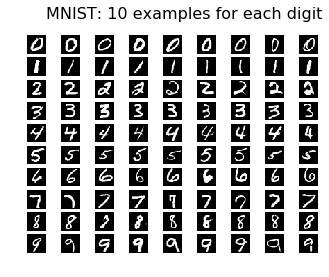

In [3]:
def P1(num_examples=10):

### STUDENT START ###

    # loop through each digit and each column for that digit
    for digit in range(0,10):
        for col in range(1,10):
            # Find the next value position of that digit in the labels
            pos = np.where(mini_train_labels==digit)[0][col]
            # set subplot to 10x10 grid
            plt.subplot(10, 10, digit * 10 + col)
            plt.imshow(mini_train_data[pos].reshape((28, 28)), cmap='gray')
            # axis labels off
            plt.axis('off')
    plt.suptitle('MNIST: {} examples for each digit'.format(num_examples), size=16)

### STUDENT END ###

P1(10)

(2) K-Nearest-Neighbors model is evaluated with k = [1,3,5,7,9] using the mini training set. Precision, recall, and F1 for each label is shown.

In [4]:
def P2(k_values):

### STUDENT START ###
    k_reports = []
    
    for k in k_values:
        # Create and train model
        clf_kn = KNeighborsClassifier(n_neighbors=k)
        clf_kn.fit(mini_train_data, mini_train_labels)
        
        # Predict on dev_data using model
        predicted = clf_kn.predict(dev_data)

        # Print out k==1 neighbors
        rep = classification_report(dev_labels, predicted, digits=2)  
        if k == 1:
            print('For k==1 neighbors:\n', rep)
        
        # Parse and generate report for KNN with k = [1, 3, 5, 7, 9]
        line = rep.split('\n')[-2]
        beg, precision, recall, f1, end = [x for x in line.split('  ') if len(x)]
        
        # Calculate accuracy: (ratio of correctly predicted observation to the total observations)
        correct = sum([i == j for i, j in zip(predicted, dev_labels)])
        accuracy = correct / len(dev_labels)

        k_reports.append((k, accuracy, precision, recall, f1))
   
    # Print report for KNN with k= [1, 3, 5, 7, 9]
    print('  MODEL      accuracy  precision   recall  f1-score')
    for item in k_reports:
        print('Neighbors {0}:   {1:.1%}     {2}      {3}    {4}'.format(*item))

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

For k==1 neighbors:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

  MODEL      accuracy  precision   recall  f1-score
Neighbors 1:   88.4%      0.89      0.88    0.88
Neighbors 3:   87.6%      0.88      0.88    0.87
Neighbors 5:   88.2%      0.89      0.88    0.88
Neighbors 7:   87.7% 

**ANSWER:** For k==1, The precision score indicates that the most difficult digit appears to be '9', and then '8'. Both also have the lowest f1-score.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###

    print('Train Size\tAccuracy\tPrecision\tRecall\t\tF1-score\t  Time')
    print("-"*90)

    for size in train_sizes:
        # Train model using k==1
        clf_kn = KNeighborsClassifier(n_neighbors=1)
        clf_kn.fit(train_data[:size], train_labels[:size])

        # Predict on dev_data and time the prediction
        start = time.time()
        predicted = clf_kn.predict(dev_data)
        elapsed = time.time() - start
        
        # Calculate accuracy and append to list
        correct = sum([i == j for i, j in zip(predicted, dev_labels)])
        accuracy = correct / len(dev_labels)
        accuracies.append(accuracy)
        
        # Build the reporting
        rep = classification_report(y_true=dev_labels, y_pred=predicted, digits=3)
        # Generate report - get the line and then parse it
        line = rep.split('\n')[-2]
        beg, precision, recall, f1, end = [x for x in line.split('  ') if len(x)]
        
        # output table
        print('{0:>8}\t {1:.1%}\t\t {2}\t\t{3}\t\t{4}\t\t{5:>6.2f}s'.format(size, accuracy, precision, recall, f1, elapsed))

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Train Size	Accuracy	Precision	Recall		F1-score	  Time
------------------------------------------------------------------------------------------
     100	 70.2%		 0.720		 0.702		 0.692		  0.14s
     200	 79.1%		 0.798		 0.791		 0.788		  0.26s
     400	 81.1%		 0.817		 0.811		 0.809		  0.51s
     800	 86.6%		 0.869		 0.866		 0.865		  1.01s
    1600	 90.5%		 0.907		 0.905		 0.905		  2.03s
    3200	 92.7%		 0.927		 0.927		 0.926		  4.09s
    6400	 93.9%		 0.939		 0.939		 0.939		  8.37s
   12800	 95.2%		 0.952		 0.952		 0.952		 16.41s
   25000	 96.2%		 0.962		 0.962		 0.962		 31.83s


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

In [6]:
def P4():

### STUDENT START ###

    size = 60000

    # Use train sizes from Problem 3 and reshape into matrix
    t_size = list(map(lambda x: [x,], train_sizes))
    
    # Fit model and predict for 60k
    linearModel = LinearRegression()
    linearModel.fit(t_size, accuracies)
    pred = linearModel.predict([[size]])
    print('Accuracy predicted (size={0}k): {1:>6.1%}'.format(size/1000, pred[0]))
        
    # Fit model and predict for 60k w/ Log Transform
    transformModel = LinearRegression()
    transform_sizes = [np.log([size]) for size in train_sizes]
    
    new_accuracies = [np.log(accuracy/(1-accuracy)) for accuracy in accuracies]
    transformModel.fit(transform_sizes, new_accuracies)    
    predT = transformModel.predict(np.log([[size]]))
    
    # Reverse Log transformation to get predicted value
    transformPred = np.exp(predT) / (1 + np.exp(predT))
    print('Accuracy predicted (size={0}k): {1:>6.1%}  (Log Transformation)'.format(size/1000, transformPred[0]))

### STUDENT END ###
    
P4()

Accuracy predicted (size=60.0k): 124.5%
Accuracy predicted (size=60.0k):  97.6%  (Log Transformation)


**ANSWER:** The predicted accuracy is > 1 since there are no restrictions for the linear regression. A log transform is applied on the accuracy data and then reversed on the predicted value to retrieve the predicted accuracy.

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]

Confusion matrix: the most confused pairs were 4's predicted to be 9's


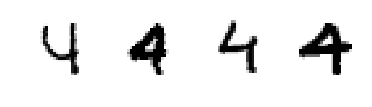

In [7]:
def P5():

### STUDENT START ###
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(mini_train_data, mini_train_labels)
    preds = model.predict(dev_data)
    print(confusion_matrix(dev_labels, preds))
    print("\nConfusion matrix: the most confused pairs were 4's predicted to be 9's")
    
    # Examples
    i = 0
    count = 0
    while count < 4:
        if dev_labels[i] == 4 and preds[i] == 9:
            mat = np.reshape(dev_data[i,], (28,28))
            plt.subplot(1, 4, count + 1)
            plt.imshow(mat, cmap = 'Greys')
            plt.axis('off')
            count += 1
        i += 1
        
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Original & blurred number examples:


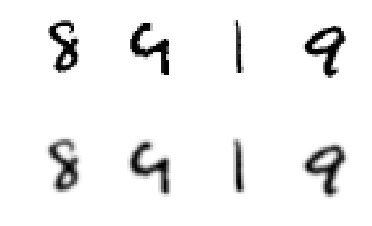

Blurred TRAINING data but NOT DEV data:
	correct: 906/1000  accuracy: 90.6%
Blurred DEV data but NOT TRAINING data:
	correct: 868/1000  accuracy: 86.8%
Blurred BOTH Training and DEV data:
	correct: 901/1000  accuracy: 90.1%


In [16]:
def P6():
    
### STUDENT START ###
    def blur(data, weights):   
        # Returns a new array of zeros
        blurData = np.zeros(data.shape)
        # For each row in original data
        for i in range(data.shape[0]):
            # Gives a 28x28 shape to an array without changing its data
            tempMat = np.reshape(data[i], (28,28))
            # Array of 
            blurMat = np.zeros((28, 28))
            for j in range(1, 27):
                for k in range(1, 27):
                    for l in range(-1, 2):
                        for m in range(-1, 2):
                            # Add weighted value to blurred matrix
                            blurMat[j][k] += tempMat[j+l][k+m] * weights[l+1][m+1]
            # Reshape blurred matrix to match original data shape
            blurData[i] = np.reshape(blurMat, (1, 784))
        return blurData        
    
    def classifiers(trainX, trainY, testX, testY):
        # Setup classifier and print accuracy for each case
        clf_kn = KNeighborsClassifier(n_neighbors=1)
        clf_kn.fit(trainX, trainY) 
        preds = clf_kn.predict(testX)
        correct, total = 0, 0
        for pred, label in zip(preds, testY):
            if pred == label: 
                correct += 1
            total += 1
        print('\tcorrect: {0}/{1}  accuracy: {2:>5.1%}'.format(correct, total, correct/total))
    
    # Used the Gaussian blur formula for weighting: http://en.wikipedia.org/wiki/Gaussian_blur
    sigma = 1
    weights = np.zeros((3, 3))
    totWeight = 0
    for i in range (-1, 2):
        for j in range (-1, 2):
            weights[i+1][j+1] = (1/(2 * np.pi * sigma**2))*np.exp(-1 * (i**2 + j**2)/(2 * sigma**2))
            totWeight += weights[i+1][j+1]

    # Normalizing weights
    for i in range (0, 3):
        for j in range(0, 3):
            weights[i][j] = weights[i][j]/totWeight
    
    # Blurring the training and dev data
    blur_mini_train_data = blur(mini_train_data, weights)
    blur_dev_data = blur(dev_data, weights)
        
    ## Displaying severael examples leveraging the code in P5.
    # Before blur examples
    print("Original & blurred number examples:")
    i = 0
    count = 0
    while count < 4:
        mat = np.reshape(dev_data[i,], (28,28))
        plt.subplot(2, 4, count + 1)
        plt.imshow(mat, cmap = 'Greys')
        plt.axis('off')
        count += 1
        i += 1
    
    # After blur examples
    i = 0
    while count < 8:
        mat = np.reshape(blur_dev_data[i,], (28,28))
        plt.subplot(2, 4, count + 1)
        plt.imshow(mat, cmap = 'Greys')
        plt.axis('off')
        count += 1
        i += 1
    plt.show()
        
    print('Blurred TRAINING data but NOT DEV data:')
    classifiers(blur_mini_train_data, mini_train_labels, dev_data, dev_labels)
    print('Blurred DEV data but NOT TRAINING data:')
    classifiers(mini_train_data, mini_train_labels, blur_dev_data, dev_labels)
    print('Blurred BOTH Training and DEV data:')
    classifiers(blur_mini_train_data, mini_train_labels, blur_dev_data, dev_labels)

### STUDENT END ###

P6()

**ANSWER:**  Blurring the Training set, but not the Dev data set seems to provide a slightly higher accuracy.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [9]:
def P7():

### STUDENT START ###

    # Fit BernoulliNB with <0.5 considered to be 0 and >0.5 to be 1
    clf_bnb = BernoulliNB(alpha=1.0, binarize=.5, class_prior=None, fit_prior=True)
    clf_bnb.fit(mini_train_data, mini_train_labels)       
    preds = clf_bnb.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: 
            correct += 1
        total += 1
    print('BinomialNB:    correct: {0}/{1}  accuracy: {2:>5.1%}'.format(correct, total, correct/total))

    # map pixel values to either 0, 1 or 2
    multiAdj = mini_train_data * 2
    multiAdj = np.rint(multiAdj)
    
    clf_mnb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    clf_mnb.fit(multiAdj, mini_train_labels)
    preds = clf_mnb.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: 
            correct += 1
        total += 1
    print('MultinomialNB: correct: {0}/{1}  accuracy: {2:>5.1%}'.format(correct, total, correct/total))

### STUDENT END ###

P7()

BinomialNB:    correct: 819/1000  accuracy: 81.9%
MultinomialNB: correct: 814/1000  accuracy: 81.4%


**ANSWER:** MultinomialNB does not improve the results. It looks like it does not make sense to have three classes maybe because the objects are lines and that gray does not really add any further information about the digit.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [10]:
def P8(alphas):
    
### STUDENT START ###

    # Run Bernoulli NB for alphas array
    clfBnb = BernoulliNB(binarize=0.5, fit_prior=False, class_prior=None)
    clfGrid = GridSearchCV(clfBnb, alphas, iid=True, cv=5)
    clfGrid.fit(mini_train_data, mini_train_labels)

    print("Alpha\tMean Score\tStd. Test Score")
    print("-"*40)
    for i in range(len(clfGrid.cv_results_['mean_test_score'])):
        print('{0}\t  {1}\t\t     {2:5.2}'.format(alphas['alpha'][i], clfGrid.cv_results_['mean_test_score'][i], 
            clfGrid.cv_results_['std_test_score'][i]))

    return clfGrid

### STUDENT END ###

# Setting Alpha 0.0 to 1.0e-10 to avoid warning
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

Alpha	Mean Score	Std. Test Score
----------------------------------------
1e-10	  0.827		     0.041
0.0001	  0.836		     0.045
0.001	  0.838		     0.045
0.01	  0.834		     0.047
0.1	  0.826		     0.045
0.5	  0.826		     0.043
1.0	  0.821		     0.042
2.0	  0.818		     0.043
10.0	  0.765		     0.045


In [11]:
print(nb.best_params_)

{'alpha': 0.001}


**ANSWER:** The best value of alpha is '0.001'. An Alpha of ~0.0 had a lower mean score, but not by much (difference = .011). This makes sense given that the optimal alpha was already pretty close to zero at 0.001.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [12]:
def P9():

### STUDENT END ###

    print("BernoulliNB (P8)               accuracy: 83.8%")
    # Train Gaussian NB
    clfGnb = GaussianNB()
    clfGnb.fit(mini_train_data, mini_train_labels)       
    preds = clfGnb.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: 
            correct += 1
        total += 1
    print('GuassianNB: correct: {0}/{1}  accuracy: {2:>5.1%}\n'.format(correct, total, correct/total))
    # theta an sigma values are zero or close to zero
    print('theta:\n' + str(clfGnb.theta_) + '\n\nsigma:\n' + str(clfGnb.sigma_))
    
    # sigma and theta values are near-zero, so add random noise: 0.3 performed the best
    adj_mini_train_data = np.zeros(mini_train_data.shape)
    for i in range(mini_train_data.shape[0]):
        for j in range(mini_train_data.shape[1]):
            adj_mini_train_data[i][j] = mini_train_data[i][j] + 0.3 * np.random.rand()

    # Train Gaussian NB using the adjusted data
    clfGnb = GaussianNB()
    clfGnb.fit(adj_mini_train_data, mini_train_labels)       
    preds = clfGnb.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: 
            correct += 1
        total += 1
    print('\nAdj. GuassianNB: correct: {0}/{1}  accuracy: {2:>5.1%}'.format(correct, total, correct/total))

### STUDENT END ###

gnb = P9()

BernoulliNB (P8)               accuracy: 83.8%
GuassianNB: correct: 593/1000  accuracy: 59.3%

theta:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

sigma:
[[2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 ...
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]]

Adj. GuassianNB: correct: 820/1000  accuracy: 82.0%


**ANSWER:** 
The problem is that the mean (theta) and standard deviation (sigma) is zero or close to zero. Adding random noise increased accuracy to ~82%, which is close to the BernoulliNB at 83.8%.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

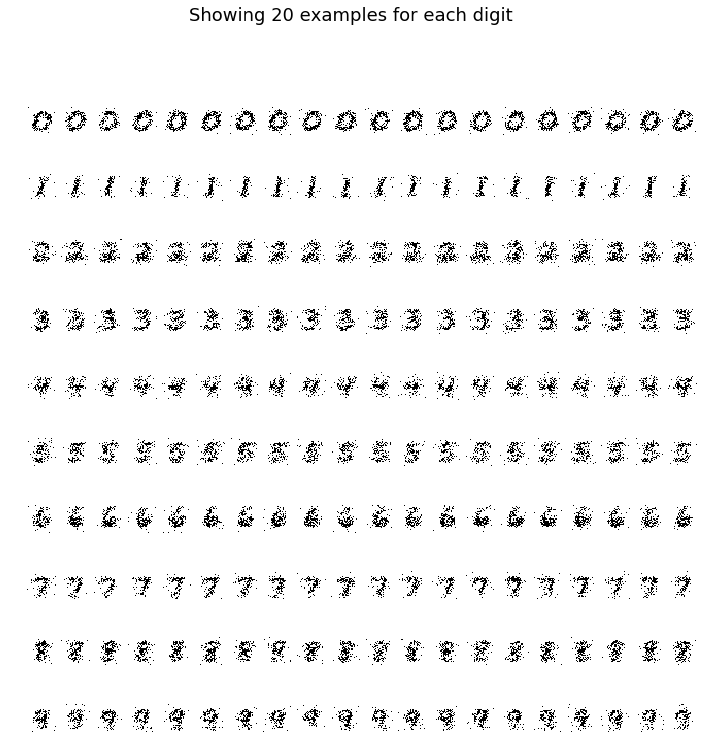

In [18]:
def P10(num_examples):

### STUDENT START ###

    # Train Bernoulli NB
    clfBnb = BernoulliNB(binarize = 0.5, fit_prior=True, class_prior=None)
    clfBnb.fit(mini_train_data, mini_train_labels)
    
    fig = plt.figure(figsize=(12, 12))
    # Generate 20 examples per digit
    for i in range(num_examples):
        for j in range(10):
            mat = np.reshape([np.exp(clfBnb.feature_log_prob_)[j] > np.random.rand(784)], (28,28))
            plt.subplot(10, num_examples, j * num_examples + i + 1)
            plt.imshow(mat, cmap = 'Greys')
            plt.axis('off')

    fig.suptitle('Showing {0} examples for each digit'.format(num_examples), size=18)
            
### STUDENT END ###

P10(20)

**ANSWER:** 
The generated digits are less crisp and defined compared to the training digits. The training digits have edges, are more distinct, and vary more from one digit to another.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [14]:
def P11(buckets, correct, total):
    
### STUDENT START ###

    # Fit BernoulliNB model with alpha=0.001 (from P8)
    clfBnb = BernoulliNB(alpha=0.001, binarize=.5, fit_prior=False)
    clfBnb.fit(mini_train_data , mini_train_labels)
    predProb = np.exp(clfBnb.predict_log_proba(dev_data))
    
    # Get the predicted probabilities and labels
    posterior_prob = np.max(predProb, axis=1)
    predicted_label = np.argmax(predProb, axis=1)
        
    # Update total and correct counts
    # Iterate for each prediction and for each posterior bucket
    for i, p in enumerate(posterior_prob):
        for j, b in enumerate(buckets):
            if p >= b:
                # add to total count
                total[j] += 1
                # check if correct and add to total correct
                if predicted_label[i] == dev_labels[i]:
                    correct[j] += 1
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total = 1000    accuracy = 0.828
p(pred) <= 0.9000000000000    total = 962    accuracy = 0.846
p(pred) <= 0.9990000000000    total = 876    accuracy = 0.884
p(pred) <= 0.9999900000000    total = 806    accuracy = 0.912
p(pred) <= 0.9999999000000    total = 736    accuracy = 0.935
p(pred) <= 0.9999999990000    total = 688    accuracy = 0.943
p(pred) <= 0.9999999999900    total = 621    accuracy = 0.947
p(pred) <= 0.9999999999999    total = 549    accuracy = 0.954
p(pred) <= 1.0000000000000    total = 526    accuracy = 0.958


**ANSWER:**  The Naive Bayes model is weakly calibrated. There is a positive correlation between posterior probability and accuracy (classifier is more accurate as the posterior is higher), but they are not very close to being equivalent.